# *CePNEM Plotting Notebook v1.0.0*

This notebook contains a collection of plotting utilities that allow the user to interact with the whole-brain data available on wormwideweb.org. If you are using your own data with this notebook, it is expected that you will have first run the companion `CePNEM-analysis.ipynb` notebook to generate the necessary data files.

One note is that many of the plotting functions here do not by default have axis labels. This is because the axis labels were input manually in the final figures for the paper, and so the functions here do not have them. You can reference the corresponding paper figures for the axis labels.

# Initialization

In [1]:
using CePNEMAnalysis, StatsBase, Plots, Plots.PlotMeasures, ProgressMeter, CePNEM, MultivariateStats,
        ColorVectorSpace, MultipleTesting, HDF5, JLD2, Gen, ANTSUNData, FlavellConstants, UMAP, ImageShow, LinearAlgebra,
        ImageCore, Clustering, Images, GLMNet, Combinatorics, Distributions, FlavellBase, ProgressMeter, PyPlot, ANTSUNData, NeuroPALData,
        EncoderModel, AnalysisBase, HypothesisTests, MultipleTesting, PyCall, SpecialFunctions, FileIO, StatsPlots, TotalVariation, DelimitedFiles, Interpolations,
        GLM, DataFrames, KernelDensity, MultiKDE, Optim, ForwardDiff, HierarchicalPosteriorModel, ConnectomePlot, ColorTypes, Random, DataStructures

## Load data

In [2]:
path_fit_results_lite = "/data1/prj_kfc/data/analysis_dict/fit_results_lite.jld2"
path_analysis_dict = "/data1/prj_kfc/data/analysis_dict/analysis_dict.jld2"

path_fit_results = "/data1/prj_kfc/data/analysis_dict/fit_results.jld2"
path_relative_encoding_strength_dict = "/data1/prj_kfc/data/analysis_dict/relative_encoding_strength.jld2";


In [3]:
fit_results = Dict()
if isfile(path_fit_results_lite)
    f = JLD2.jldopen(path_fit_results_lite)
    fit_results = f["fit_results_lite"]
    close(f)
end

In [4]:
analysis_dict = Dict()
if isfile(path_analysis_dict)
    f = JLD2.jldopen(path_analysis_dict)
    analysis_dict = f["analysis_dict"]
    close(f)
end;

In [5]:
θh_pos_is_ventral = analysis_dict["θh_pos_is_ventral"];

In [6]:
path_h5_data = "/data1/prj_kfc/data/processed_h5"


get_h5_data = dataset -> import_data(joinpath(path_h5_data, "$(dataset)-data.h5"))


datasets_gfp = ["2022-01-07-03", "2022-03-16-01", "2022-03-16-02"]
datasets_baseline = ["2021-05-26-07", "2021-06-11-01", "2021-08-04-06", "2021-08-17-01", "2021-08-18-01", "2021-09-22-05", "2021-10-26-01", "2021-11-12-01", "2021-11-12-05", "2022-01-09-01", "2022-01-17-01", "2022-04-05-01", "2022-04-12-04", "2022-04-14-04"]
datasets_stim = ["2021-09-06-09", "2021-09-14-01", "2021-09-14-05", "2021-09-23-01", "2021-09-30-01"]
datasets_stim_1600 = ["2022-02-08-04", "2022-02-16-01", "2022-02-16-04", "2022-03-15-04", "2022-03-22-01", "2022-04-18-04"]
datasets_neuropal_1600 = ["2022-06-14-01", "2022-06-14-07", "2022-06-14-13", "2022-06-28-01", "2022-06-28-07", "2022-07-15-06", "2022-07-15-12", "2022-07-20-01", "2022-07-26-01", "2022-08-02-01", "2023-01-23-08", "2023-01-23-15", "2023-01-23-21", "2023-01-19-01", "2023-01-19-08", "2023-01-19-22", "2023-01-09-28", "2023-01-17-01", "2023-01-19-15", "2023-01-23-01", "2023-03-07-01"];
datasets_neuropal_stim = ["2022-12-21-06", "2023-01-05-01", "2023-01-05-18", "2023-01-06-01", "2023-01-06-08", "2023-01-06-15", "2023-01-09-08", "2023-01-09-15", "2023-01-09-22", "2023-01-10-07", "2023-01-10-14", "2023-01-13-07", "2023-01-16-01", "2023-01-16-08", "2023-01-16-15", "2023-01-16-22", "2023-01-17-07", "2023-01-17-14", "2023-01-18-01"]
datasets_neuropal_800 = []
datasets_baseline_merged = ["2021-05-26-07", "2021-06-11-01", "2021-08-04-06", "2021-08-17-01", "2021-08-18-01", "2021-09-22-05", "2021-10-26-01", "2021-11-12-01", "2021-11-12-05", "2022-01-09-01"]
datasets_baseline_1600 = ["2022-01-17-01", "2022-04-05-01", "2022-04-12-04", "2022-04-14-04"];


datasets_neuropal = deepcopy(datasets_neuropal_800)
append!(datasets_neuropal, datasets_neuropal_1600)
append!(datasets_neuropal, datasets_neuropal_stim)

datasets_gcamp = String[]
datasets_swf415 = String[]
datasets = String[]
for d in [datasets_baseline, datasets_stim, datasets_stim_1600]
    append!(datasets_gcamp, d)
    append!(datasets, d)
    append!(datasets_swf415, d)
end
append!(datasets, datasets_neuropal)
append!(datasets_gcamp, datasets_neuropal)
append!(datasets, datasets_gfp);

datasets_stim_all = deepcopy(datasets_stim)
append!(datasets_stim_all, datasets_stim_1600);
append!(datasets_stim_all, datasets_neuropal_stim);
datasets_neuropal_baseline = [d for d in datasets_neuropal if !(d in datasets_stim_all)];

In [7]:
stim_times = Dict()
for dataset in datasets_stim_all
    stim_times[dataset] = Int(get_h5_data(dataset)["stim_begin_confocal"][1])
end

## Load larger `fit_results` dictionary

Most blocks of code do not require this larger file (~20GB) to be loaded into memory, but there are a few code blocks that need it. For those blocks of code, you can load it by uncommenting and running the following cell:

In [102]:
# fit_results = Dict()
# if isfile(path_fit_results)
#     f = JLD2.jldopen(path_fit_results)
#     fit_results = f["fit_results"]
#     close(f)
# end

## Load `relative_encoding_strength` dictionary

Most blocks of code do not require loading this dictionary, which is fairly large (~20GB). For those that do, you can load it by uncommenting and running this code:

In [ ]:
# relative_encoding_strength = Dict()
# if isfile(path_relative_encoding_strength_dict)
#     f = JLD2.jldopen(path_relative_encoding_strength_dict)
#     relative_encoding_strength = f["relative_encoding_strength"]
#     close(f)
# end;

## Plotting parameters

Here, you can set plotting parameters such as the default font, font size, and save location.

In [13]:
rc_params = PyDict(pyimport("matplotlib")["rcParams"]);
rc_params["font.sans-serif"] = ["Arial"];
rc_params["font.size"] = 7;
fix_plot() = (margins(0.05); tick_params(direction = "out");
    ax = gca(); ax[:xaxis][:tick_bottom]();
    ax[:yaxis][:tick_left]();
    ax[:spines]["top"]["set_visible"](false);
    ax[:spines]["right"]["set_visible"](false););

path_fig_root = "/data1/prj_kfc/figure/manuscript/cell_draft2" # this is where figures will be saved to


"/data1/prj_kfc/figure/manuscript/cell_draft2"

In [14]:
fnt = Plots.font("Arial", 7)
default(titlefont=fnt, guidefont=fnt, tickfont=fnt, legendfont=fnt)

default(grid=false)
default(color=:auto)

## Manually specify state changes

For heat-stim datasets, the hypothesized time of state change is always set to the time of the heat-stim. For other datasets, we do not yet have an automated way to detect state changes, so you must manually specify the time of state change for each dataset.
For baseline datasets, we recommend examining the relative model performance plots to determine the time of state change.

We are actively working on improving CePNEM to automate the detection of state changes in baseline datasets.

In [15]:
manual_hypothesized_state_changes = Dict()
manual_hypothesized_state_changes["2022-04-05-01"] = 9.25
manual_hypothesized_state_changes["2022-08-02-01"] = 3.89;
manual_hypothesized_state_changes["2022-06-14-07"] = 11;
manual_hypothesized_state_changes["2022-06-14-13"] = 8.3;
manual_hypothesized_state_changes["2022-06-28-01"] = 8.0;
manual_hypothesized_state_changes["2022-06-28-07"] = 5.3;
manual_hypothesized_state_changes["2022-07-15-12"] = 7.2;
manual_hypothesized_state_changes["2022-07-20-01"] = 5.2;


# Explore neural encoding properties

In this section, you can examine and plot aggregate encoding statistics across animals, as well as examine the encoding properties of individual neurons.

## Global statistics

### Compute fraction of neurons that encode any behavior

You can change the `key` to change which datasets to consider. For example:
 - `n_neurons_npred` will find the fraction of neurons in SWF415 baseline datasets that show any behavioral encoding
 - `n_neurons_npred_gfp` will find the fraction of neurons in GFP datasets that show any behavioral encoding
 - `n_neurons_npred_neuropal_baseline` will find the fraction of neurons in NeuroPAL baseline datasets that show any behavioral encoding

In [8]:
let
    key = "n_neurons_npred"
    sum(analysis_dict[key][2:4]) / sum(analysis_dict[key])
end

0.5834165834165834

### Figure 2A: Fraction of neurons encoding each behavior

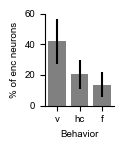

In [92]:
let
    save_fig = false # set to true to save figure
    datasets_use = datasets_baseline
    
    if save_fig
        path_fig = joinpath(path_fig_root, "figure2", "encoding-survey")
        create_dir(joinpath(path_fig_root, "figure2"))
        create_dir(path_fig)
    end

    list_enc = []
    for dataset = datasets
        if !(dataset in keys(analysis_dict["enc_stat_dict_pt"]))
            continue
        end
        enc_dict = analysis_dict["enc_stat_dict_pt"][dataset]
        push!(list_enc, enc_dict["n_neurons_beh"] ./ enc_dict["n_neurons_tot_all"])
    end
    
    a = hcat(list_enc...)
    u = meanprj(a, dims=2)
    s = dropdims(std(a, dims=2), dims=2)

    # PyPlot.figure(figsize=(0.75,1.5)) # size in Illustrator
    PyPlot.figure(figsize=(1.25,1.5))
    PyPlot.bar(0:2, u * 100, yerr=s * 100, color="gray")

    PyPlot.xticks(0:2, ["v", "hc", "f"], rotation=0)
    PyPlot.ylim(0,60)
    ylabel("% of enc neurons")
    xlabel("Behavior")
    fix_plot()
    tight_layout()
    
    if save_fig
        path_fig = joinpath(path_fig, "enc_b.pdf")
        PyPlot.savefig(path_fig)
    end
end

### Figure 2B: Distribution of number of behaviors encoded

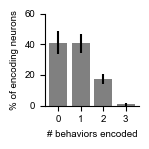

In [93]:
let
    save_fig = false # set to true to save the figure

    datasets_use = datasets_baseline
    enc_key = "enc_stat_dict_pt"

    if save_fig
        path_fig = joinpath(path_fig_root, "figure2", "encoding-survey")
        create_dir(joinpath(path_fig_root, "figure2"))
        create_dir(path_fig)
    end
    
    list_enc = []
    
    for dataset = datasets_use 
        if !(dataset in keys(analysis_dict[enc_key]))
            continue
        end
        enc_dict = analysis_dict[enc_key][dataset]
        frac = enc_dict["n_neurons_npred"] ./ enc_dict["n_neurons_tot_all"]
        push!(list_enc, frac)
    end

    a = hcat(list_enc...)
    u = meanprj(a, dims=2)
    s = dropdims(std(a, dims=2), dims=2)

    # PyPlot.figure(figsize=(1,1.5)) # Illustrator size
    PyPlot.figure(figsize=(1.5,1.5))
    PyPlot.bar(0:3, u * 100, yerr=s * 100, color="gray")
    PyPlot.xticks(0:3, 0:3)

    PyPlot.ylim(0,60)

    ylabel("% of encoding neurons")
    xlabel("# behaviors encoded")
    fix_plot()
    tight_layout()

    if save_fig
        path_fig = joinpath(path_fig, "enc_n.pdf")
        PyPlot.savefig(path_fig)
    end
end

### Figure 2C and S2I-J: Distribution of EWMA tau values

Set `beh_plot` to the set of behaviors you want to plot the EWMA values of. The code contains three preset values corresponding to three figure panels in the paper.

12.5


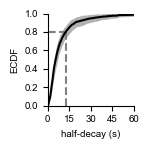

In [94]:
let
    beh_plot = [["all"]] # for Figure 2C

    # beh_plot = [["v", "rev"], ["v", "fwd"]] # for Figure S2I
    # beh_plot = [["v", "all"], ["θh", "all"], ["P", "all"]] # for Figure S2J
    
    save_fig = false # set to true to save figure
    compute_mse = false # set this to true to use MSE for error bars instead of std

    colors = []
    if beh_plot == [["all"]]
        colors = ["black"]
    elseif beh_plot == [["v", "rev"], ["v", "fwd"]]
        colors = [color_to_rgba(palette(:PiYG)[1], 1.0), color_to_rgba(palette(:PiYG)[end], 1.0)]
    elseif beh_plot == [["v", "all"], ["θh", "all"], ["P", "all"]]
        colors = ["red", "green", "blue"]
    end
    enc_key = "neuron_categorization"

    rg_ecdf = 0.0:0.1:60.0 

    list_ecdf = [[] for i=1:length(beh_plot)]
    
    
    for dataset = datasets_baseline
        list_ = [Float64[] for i=1:length(beh_plot)]
        for idx_rg = 1:length(fit_results[dataset]["ranges"])
            for (i, behs) = enumerate(beh_plot)
                idx_enc = analysis_dict[enc_key][dataset][idx_rg]
                for sub_beh = behs
                    idx_enc = idx_enc[sub_beh]
                end
                if length(idx_enc) == 0
                    continue
                end
                append!(list_[i], median(fit_results[dataset]["sampled_tau_vals"][idx_rg,idx_enc,:], dims=2)[:])
            end
        end

        h = [ecdf(list_[i]) for i=1:length(list_)]
        for i=1:length(list_)
            if length(list_[i]) == 0
                continue
            end
            push!(list_ecdf[i], h[i].(rg_ecdf))
        end
    end
    
    wts = [hcat(list_ecdf[i]...) for i=1:length(list_ecdf)]
    u = [meanprj(wts[i], dims=2) for i=1:length(wts)]
    s = [dropdims(std(wts[i], dims=2), dims=2) ./ (compute_mse ? sqrt(length(datasets_baseline)) : 1) for i=1:length(wts)]
    
    x = rg_ecdf
    y1 = [u[i] .- s[i] for i=1:length(wts)]
    y2 = u
    y3 = [u[i] .+ s[i] for i=1:length(wts)]

    PyPlot.figure(figsize=(1.5,1.5))
    

    if beh_plot == [["all"]]
        idx_8 = findfirst(u[1] .> 0.8)
        println(rg_ecdf[idx_8])
        PyPlot.plot([x[idx_8],x[idx_8]],[0,0.8], color="gray", linestyle="--")
        PyPlot.plot([0,x[idx_8]],[0.8,0.8], color="gray", linestyle="--")
    end

    for i=1:length(wts)
        PyPlot.plot(x, y2[i], color=colors[i])
        PyPlot.fill_between(x, y1[i], y3[i], color=colors[i], alpha=0.3, linewidth=0)
    end


    PyPlot.ylabel("ECDF")
    PyPlot.xlabel("half-decay (s)")

    PyPlot.xlim(0,60)
    PyPlot.ylim(0,1.0)
    PyPlot.yticks(0:0.2:1)
    PyPlot.xticks(0:15:60)
    fix_plot()
    tight_layout()
    
    if save_fig
        if beh_plot == [["all"]]
            path_fig = joinpath(path_fig_root, "figure2", "encoding-survey")
            create_dir(joinpath(path_fig_root, "figure2"))
            create_dir(path_fig)
            path_fig = joinpath(path_fig, "tau-ecdf.pdf")
        elseif beh_plot == [["v", "rev"], ["v", "fwd"]]
            path_fig = joinpath(path_fig_root, "figureS2", "encoding-survey")
            create_dir(joinpath(path_fig_root, "figureS2"))
            create_dir(path_fig)
            path_fig = joinpath(path_fig, "tau-ecdf-fwdvsrev.pdf")
        elseif beh_plot == [["v", "all"], ["θh", "all"], ["P", "all"]]
            path_fig = joinpath(path_fig_root, "figureS2", "encoding-survey")
            create_dir(joinpath(path_fig_root, "figureS2"))
            create_dir(path_fig)
            path_fig = joinpath(path_fig, "tau-ecdf-behcompare.pdf")
        end
        PyPlot.savefig(path_fig, transparent=true)
    end
end

### Statistical test comparing EWMA distribution of forward vs reverse neurons

In [34]:
let
    frac_long_fwd = Float64[]
    frac_long_rev = Float64[]
    for dataset in datasets_baseline
        n_long_fwd = 0
        n_all_fwd = 0
        n_long_rev = 0
        n_all_rev = 0
        for rng=1:2
            for neuron in analysis_dict["neuron_categorization"][dataset][rng]["v"]["fwd"]
                n_all_fwd += 1
                if median(fit_results[dataset]["sampled_tau_vals"][rng,neuron,:]) >= 20
                    n_long_fwd += 1
                end
            end
            for neuron in analysis_dict["neuron_categorization"][dataset][rng]["v"]["rev"]
                n_all_rev += 1
                if median(fit_results[dataset]["sampled_tau_vals"][rng,neuron,:]) >= 20
                    n_long_rev += 1
                end
            end
        end
        push!(frac_long_fwd, n_long_fwd / n_all_fwd)
        push!(frac_long_rev, n_long_rev / n_all_rev)
    end
    MannWhitneyUTest(frac_long_fwd, frac_long_rev)
end

Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.088838

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0286

Details:
    number of observations in each group: [14, 14]
    Mann-Whitney-U statistic:             146.0
    rank sums:                            [251.0, 155.0]
    adjustment for ties:                  132.0
    normal approximation (μ, σ):          (48.0, 21.6983)


### Figure S2D: Fraction of encoding neurons in GCaMP vs GFP and wrong-behavior control datasets

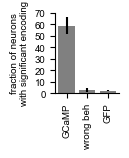

In [96]:
let
    save_fig = false # set to true to save the figure

    create_dir(joinpath(path_fig_root, "figureS2"))
    
    μ_scramble, σ_scramble = (0.026989835095423964,0.020278087504378265) # computed from running the `CePNEM-analysis.ipynb` notebook on the wrong-behavior control datasets
    fracs_gcamp = Float64[]
    tot = 0
    for dataset = datasets_baseline
        tot += sum(analysis_dict["enc_stat_dict"][dataset]["n_neurons_npred"][2:4]) 
        frac = sum(analysis_dict["enc_stat_dict"][dataset]["n_neurons_npred"][2:4]) / fit_results[dataset]["num_neurons"]
        push!(fracs_gcamp, frac)
    end
    μ_gcamp = mean(fracs_gcamp)
    σ_gcamp = std(fracs_gcamp)
        
    fracs_gfp = Float64[]
    for dataset = datasets_gfp
        frac = sum(analysis_dict["enc_stat_dict"][dataset]["n_neurons_npred"][2:4]) / fit_results[dataset]["num_neurons"]
        push!(fracs_gfp, frac)
    end
    μ_gfp = mean(fracs_gfp)
    σ_gfp = std(fracs_gfp)
    
    # PyPlot.figure(figsize=(1.0,1.6)) # Illustrator size
    PyPlot.figure(figsize=(1.3,1.6))
    PyPlot.bar(1:3, 100 .*[μ_gcamp, μ_scramble, μ_gfp], yerr=100 .*[σ_gcamp, σ_scramble, σ_gfp], color="gray")
    PyPlot.xticks(1:3, ["GCaMP", "wrong beh", "GFP"], rotation=90)
    PyPlot.ylim(0,70)
    PyPlot.ylabel("fraction of neurons\nwith significant encoding")
    PyPlot.yticks(0:10:70)
    fix_plot()
    tight_layout()
    if save_fig
        PyPlot.savefig(joinpath(path_fig_root, "figureS2/enc_controls.pdf"), transparent=true)
    end
end

### Explore neuron subcategorization tuning (Figure 2E)

This code requires loading the `relative_encoding_strength` dictionary (~20GB).

In [26]:
let
    n_subenc = normalize_subencodings(sum_subencodings(fit_results, analysis_dict, relative_encoding_strength, datasets_baseline, mode="sufficient"))["v"]
    println(n_subenc["fwd_pos_rev_neg"] + n_subenc["rev_pos_fwd_neg"])
    n_subenc
end

0.036036036036036036


Dict{Any, Any} with 8 entries:
  "analog_neg"             => 0.045045
  "fwd_slope_neg_rect_neg" => 0.045045
  "analog_pos"             => 0.0915916
  "fwd_pos_rev_neg"        => 0.003003
  "rev_slope_pos_rect_neg" => 0.195195
  "rev_slope_neg_rect_pos" => 0.352853
  "fwd_slope_pos_rect_pos" => 0.234234
  "rev_pos_fwd_neg"        => 0.033033

### Statistical comparison of encoding change fraction between baseline and heat-stim datasets in NeuroPAL animals

In [37]:
let
    ec_frac_baseline = 0
    ec_baseline = Int64[]
    enc_baseline = Int64[]
    ec_frac_stim = 0
    ec_stim = Int64[]
    enc_stim = Int64[]
    for dataset in datasets_neuropal
        if length(fit_results[dataset]["ranges"]) < 2
            continue
        end
        k = "enc_stat_dict"

        n_enc = analysis_dict[k][dataset]["n_neurons_tot_all"] - analysis_dict[k][dataset]["n_neurons_npred"][1]
        n_ec = length(analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["all"])

        if dataset in datasets_neuropal_baseline
            ec_frac_baseline += n_ec / n_enc
            push!(ec_baseline, n_ec)
            push!(enc_baseline, n_enc)
        elseif dataset in datasets_neuropal_stim
            ec_frac_stim += n_ec / n_enc
            push!(ec_stim, n_ec)
            push!(enc_stim, n_enc)
        end
    end
    println("Baseline: $ec_frac_baseline, $(sum(ec_baseline) / sum(enc_baseline))")
    println("Stim: $ec_frac_stim, $(sum(ec_stim) / sum(enc_stim))")
    println(MannWhitneyUTest(ec_baseline ./ enc_baseline, ec_stim ./ enc_stim))
end


Baseline: 4.967589862919447, 0.2437417654808959
Stim: 6.500218194305073, 0.346969696969697
Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0952381

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0213

Details:
    number of observations in each group: [21, 19]
    Mann-Whitney-U statistic:             114.0
    rank sums:                            [517.0, 303.0]
    adjustment for ties:                  6.0
    normal approximation (μ, σ):          (-85.5, 36.9205)



## Individual neuron exploration

### Find all instances of a given neuron in NeuroPAL animals

This code will output a list of tuples `(dataset, n)`, where `n` is the index of the neuron in that dataset's trace array matrix.

In [38]:
analysis_dict["matches"]["AVA"] 

66-element Vector{Any}:
 ("2022-06-14-01", 13)
 ("2022-06-14-07", 76)
 ("2022-06-14-13", 133)
 ("2022-06-14-13", 127)
 ("2022-06-28-01", 138)
 ("2022-06-28-01", 80)
 ("2022-06-28-07", 83)
 ("2022-06-28-07", 116)
 ("2022-07-15-06", 15)
 ("2022-07-15-06", 20)
 ("2022-07-15-12", 118)
 ("2022-07-15-12", 39)
 ("2022-07-20-01", 70)
 ⋮
 ("2023-01-10-14", 87)
 ("2023-01-13-07", 76)
 ("2023-01-13-07", 101)
 ("2023-01-16-01", 3)
 ("2023-01-16-01", 78)
 ("2023-01-16-08", 134)
 ("2023-01-16-08", 69)
 ("2023-01-16-15", 53)
 ("2023-01-17-07", 17)
 ("2023-01-17-14", 86)
 ("2023-01-18-01", 17)
 ("2023-01-18-01", 83)

### Get encoding statistics about a single neuron

This code requires loading both the `relative_encoding_strength` dictionary (~20GB) and the larger `fit_results` dictionary (another ~20GB).

In [106]:
let
    dataset = "2022-08-02-01"
    rng = 2
    neuron = 151
    get_neuron_category(dataset, rng, neuron, fit_results, analysis_dict["neuron_categorization"], relative_encoding_strength)
end

([("θh", "ventral"), ("θh", "fwd_ventral"), ("θh", "all")], [0.5762451522804826, 0.36069559478873364, 0.04494548773541285], 3.351925781276345)

### Find all neurons with certain encoding properties

This section allows you to find neurons with desired properties, for example encoding a certain type of behavior, having certain decay parameters, and so on.

In [41]:
for dataset in datasets_baseline
    for rng=1:2
        for neuron = 1:size(fit_results[dataset]["trace_array"], 1)
            # look for neurons that encode forward locomotion
            if !(neuron in analysis_dict["neuron_categorization"][dataset][rng]["v"]["fwd"])
                continue
            end

            
            mean_tau = mean(fit_results[dataset]["sampled_tau_vals"][rng,neuron,:])
            # look for neurons with long time constants
            if mean_tau < 12.5
                continue
            end
            # look for confident long-tau neurons
            std_tau = std(fit_results[dataset]["sampled_tau_vals"][rng,neuron,:])
            if std_tau / mean_tau >= 0.5
                continue
            end
            
            ## look for neurons with high encoding strength
            ## requires loading the `relative_encoding_strength` dictionary

            # if mean(analysis_dict["relative_encoding_strength"][dataset][rng][neuron]["v"]) < 0.5
            #     continue
            # end

            println("$dataset $rng $neuron")
        end
    end
end

2021-05-26-07 1 7
2021-05-26-07 1 18
2021-05-26-07 1 46
2021-05-26-07 1 47
2021-05-26-07 1 51
2021-05-26-07 1 87
2021-05-26-07 1 126
2021-05-26-07 2 7
2021-05-26-07 2 14
2021-05-26-07 2 18
2021-05-26-07 2 23
2021-05-26-07 2 63
2021-05-26-07 2 123
2021-05-26-07 2 126
2021-05-26-07 2 131
2021-05-26-07 2 138
2021-06-11-01 1 36
2021-06-11-01 1 56
2021-06-11-01 1 87
2021-06-11-01 1 94
2021-06-11-01 1 112
2021-06-11-01 1 118
2021-06-11-01 1 131
2021-06-11-01 1 137
2021-06-11-01 1 140
2021-06-11-01 1 158
2021-06-11-01 1 159
2021-06-11-01 1 162
2021-06-11-01 2 59
2021-06-11-01 2 61
2021-06-11-01 2 70
2021-06-11-01 2 81
2021-06-11-01 2 118
2021-06-11-01 2 144
2021-06-11-01 2 145
2021-08-04-06 1 44
2021-08-04-06 1 48
2021-08-04-06 1 50
2021-08-04-06 1 57
2021-08-04-06 1 86
2021-08-04-06 1 95
2021-08-04-06 1 96
2021-08-04-06 1 102
2021-08-04-06 1 113
2021-08-04-06 1 134
2021-08-04-06 1 137
2021-08-04-06 1 146
2021-08-04-06 1 147
2021-08-04-06 2 50
2021-08-04-06 2 84
2021-08-04-06 2 147
2021-08-17

### Plot individual neural and/or behavioral traces

The following code PyPlot individual neural traces. You can set `panel_plot = nothing` and manually enter which neurons you'd like to plot, or you can use one of the preset options to plot the neurons or behaviors (by setting `plot_behavior` to `v`, `θh`, or `P`) for that dataset.

There are many pre-set options for `panel_plot`, which will cause the code to plot the data corresponding to that figure panel in the paper (or panel that got cut from the paper due to space).

To plot the CePNEM model fits, it is necessary to load the larger `fit_results` dictionary. The model fits will appear as orange in the training data and green in data the model was not trained on. The neural data will always appear as blue.

Pumping variation in the time range plotted: 0.0
Neuron 5 category in range 1: ([("v", "fwd"), ("v", "fwd_slope_pos"), ("v", "rev_slope_pos"), ("v", "all")], [0.9858587892229208, 0.012643721101025499, 0.0005810052371108991], 3.279603779985768)
Neuron 5 category in range 2: ([("v", "fwd"), ("v", "fwd_slope_pos"), ("v", "rev_slope_pos"), ("v", "all")], [0.9977641747716796, 0.0014678198509091244, 0.000313655870506521], 2.556094913292786)
Neuron 5 overall τ mean: 2.933682288726284, std: 0.4257129090166775


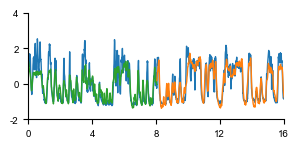

In [107]:
let
    # automatically get neurons and plot styles for the given figure panel, set to `nothing` to manually set them
    panel_plot = nothing # set to Fig2F, Fig2G1, Fig2G2, Fig2H1, Fig2H2, Fig6E1, Fig6E2, Fig6G1, Fig6G2, Fig6G3, Fig6G4, Fig7AVK, Fig7SMDD, Fig7OLL, Fig7IL1D, FigS2B1, FigS2B2, FigS2B3, FigS2B4, FigS2B5, FigS2M1, FigS2M2, FigS6F1, or FigS6F2.

    ewma_delay = 0 # Amount of time (in frames) after the beginnig of a dataset to skip model plotting. The latest CePNEM model automatically fits the initial condition, so it is recommended to leave this at 0.

    save_fig = false # set to true to save the figure
    print_info = true # set to true to print identity, categorization, and τ for neurons, and pumping variation
    show_labels = false # set to true to show axis labels on the figure
    show_neuron_labels = false # set to true to show neuron labels on the figure
    use_title = false # set to true to show figure title
    plot_fit = true # set to true to show median CePNEM fit for the neurons
    behavior_after_neuron = false # set to true to plot behavior on the same plot as the neuron
    print_neuropal_info = true # set to true to print NeuroPAL information about the current neuron, if applicable

    y_crop = (-Inf, Inf) # crop y-axis at these points. Most useful if plotting multiple neurons vertically, so they don't crash into each other.

    if isnothing(panel_plot)
        # if `panel_plot` is `nothing`, manually set neurons and plot style
        dataset = "2021-08-18-01" # dataset to plot. If it's a heat-stim dataset, set `x_lim` to (-4,12); otherwise set it to (0,16)
        rng = 2 # range to fit model
        neurons_plot = [5] # neurons to plot
        plot_behavior = nothing # behavior to plot
        print_neuropal_info = true # set to true to print NeuroPAL neuron identities for the neuron and put it on the plot title

        y_offsets = zeros(length(neurons_plot)) # y-offsets for each neuron
        plot_rev = false # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = false # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        plot_fit = true
        fig_size = (3,1.5) # size of the figure panel
        y_ticks = (-2:2:4, ["$(i)" for i in -2:2:4]) # y tick mark locations and labels
        y_lim = (-2,4) # y-axis limits

        if dataset in datasets_stim_all
            if dataset in datasets_neuropal
                x_lim = (-8,8)
            else
                x_lim = (-4,12) # x-axis limits
            end
            x_step = 4 # x-axis tick step
        else
            x_lim = (0,16) # x-axis limits
            x_step = 4 # x-axis tick step
        end


        create_dir(joinpath(path_fig_root, "figure2")) # create directory to save the figure
        save_dir = joinpath(path_fig_root, "figure2/$(dataset)_example neurons") # directory to save the figure
    elseif panel_plot == "Fig7AVK"
        # if `panel_plot` is `nothing`, manually set neurons and plot style
        dataset =  "2023-01-13-07"       # dataset to plot. If it's a heat-stim dataset, set `x_lim` to (-4,12); otherwise set it to (0,16)
        rng = 1 # range to fit model
        neurons_plot = [68] # neurons to plot
        plot_behavior = nothing # behavior to plot

        y_offsets = zeros(length(neurons_plot)) # y-offsets for each neuron
        plot_rev = false # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = false # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        plot_fit = true
        fig_size = (2.5,1.5) # size of the figure panel
        y_ticks = (-3:1:4, ["$(i)" for i in -3:1:4]) # y tick mark locations and labels
        y_lim = (-3,4) # y-axis limits
        x_lim = (-8,8)
        x_step = 4

        create_dir(joinpath(path_fig_root, "figure7")) # create directory to save the figure
        save_dir = joinpath(path_fig_root, "figure7/ec_example_neurons") # directory to save the figure
    elseif panel_plot == "Fig7SMDD"
        # if `panel_plot` is `nothing`, manually set neurons and plot style
        dataset =  "2023-01-16-15"       # dataset to plot. If it's a heat-stim dataset, set `x_lim` to (-4,12); otherwise set it to (0,16)
        rng = 1 # range to fit model
        neurons_plot = [48] # neurons to plot
        plot_behavior = nothing # behavior to plot

        y_offsets = zeros(length(neurons_plot)) # y-offsets for each neuron
        plot_rev = false # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = false # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        plot_fit = true
        fig_size = (2.5,1.5) # size of the figure panel
        y_ticks = (-3:1:4, ["$(i)" for i in -3:1:4]) # y tick mark locations and labels
        y_lim = (-3,4) # y-axis limits
        x_lim = (-8,8)
        x_step = 4

        create_dir(joinpath(path_fig_root, "figure7")) # create directory to save the figure
        save_dir = joinpath(path_fig_root, "figure7/ec_example_neurons") # directory to save the figure
    elseif panel_plot == "Fig7OLL"
        # if `panel_plot` is `nothing`, manually set neurons and plot style
        dataset = "2023-01-06-08" # dataset to plot. If it's a heat-stim dataset, set `x_lim` to (-4,12); otherwise set it to (0,16)
        rng = 1 # range to fit model
        neurons_plot = [80] # neurons to plot
        plot_behavior = nothing # behavior to plot

        y_offsets = zeros(length(neurons_plot)) # y-offsets for each neuron
        plot_rev = false # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = false # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        plot_fit = true
        fig_size = (2.5,1.5) # size of the figure panel
        y_ticks = (-3:1:4, ["$(i)" for i in -3:1:4]) # y tick mark locations and labels
        y_lim = (-3,4) # y-axis limits
        x_lim = (-8,8)
        x_step = 4

        create_dir(joinpath(path_fig_root, "figure7")) # create directory to save the figure
        save_dir = joinpath(path_fig_root, "figure7/ec_example_neurons") # directory to save the figure
    elseif panel_plot == "Fig7IL1D"
        # if `panel_plot` is `nothing`, manually set neurons and plot style
        dataset = "2023-01-06-08" # dataset to plot. If it's a heat-stim dataset, set `x_lim` to (-4,12); otherwise set it to (0,16)
        rng = 1 # range to fit model
        neurons_plot = [91] # neurons to plot
        plot_behavior = nothing # behavior to plot

        y_offsets = zeros(length(neurons_plot)) # y-offsets for each neuron
        plot_rev = false # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = false # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        plot_fit = true
        fig_size = (2.5,1.5) # size of the figure panel
        y_ticks = (-3:1:4, ["$(i)" for i in -3:1:4]) # y tick mark locations and labels
        y_lim = (-3,4) # y-axis limits
        x_lim = (-8,8)
        x_step = 4

        create_dir(joinpath(path_fig_root, "figure7")) # create directory to save the figure
        save_dir = joinpath(path_fig_root, "figure7/ec_example_neurons") # directory to save the figure
    elseif panel_plot == "Fig2F"
        dataset = "2021-08-18-01" # dataset to plot
        rng = 2 # range to fit model
        neurons_plot = [120,131,5,83,125]
        plot_behavior = nothing # behavior to plot
        
        y_offsets = [0,4.5,9,12.5,15.5] # y-axis offsets for each neuron
        plot_rev = true # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = true # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        fig_size=(4,3.3)
        y_ticks = (-2:3, ["$(i)" for i in -2:3]) # y tick mark locations and labels
        y_lim = (-2,3.2+maximum(y_offsets)) # y-axis limits
        x_lim = (0,8) .+ fit_results["2021-08-18-01"]["avg_timestep"]/60*fit_results["2021-08-18-01"]["ranges"][2][1] # x-axis limits
        x_step = 2 # x-axis tick step

        y_crop = (-2,3.2)

        ewma_delay = 10

        create_dir(joinpath(path_fig_root, "figure2"))
        save_dir = joinpath(path_fig_root, "figure2/$(dataset)-velocity-neurons") # directory to save the figure
    elseif panel_plot == "Fig2G1"
        dataset = "2021-08-18-01" # dataset to plot
        rng = 2 # range to fit model
        neurons_plot = [8,79,90] # neurons to plot
        plot_behavior = nothing # behavior to plot
        
        y_offsets = [0,5,10] # y-axis offsets for each neuron
        plot_rev = true # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = true # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        fig_size=(2.75,1.2+0.163*maximum(y_offsets)) # size of the figure panel
        y_ticks = (-2:2:4, ["$(i)" for i in -2:2:4]) # y tick mark locations and labels
        y_lim = (-2,4+maximum(y_offsets)) # y-axis limits
        x_lim = (0,4) .+ fit_results["2021-08-18-01"]["avg_timestep"]/60*fit_results["2021-08-18-01"]["ranges"][2][1] # x-axis limits
        x_step = 1 # x-axis tick step

        create_dir(joinpath(path_fig_root, "figure2"))
        save_dir = joinpath(path_fig_root, "figure2/$(dataset)-hc-neurons") # directory to save the figure
    elseif panel_plot == "Fig2G2"
        dataset = "2021-08-18-01" # dataset to plot
        rng = 2 # range to fit model
        neurons_plot = [] # neurons to plot
        plot_behavior = "θh" # behavior to plot
        
        y_offsets = [] # y-axis offsets for each neuron
        plot_rev = true # plot reversal events in red
        plot_neuron = false # plot neuron (if `false`, plot only behavior)
        is_split = true # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        fig_size=(2.75,1) # size of the figure panel
        y_lim = (-π/2,π/3)
        y_ticks = (-π/2:π/6:π/3, ["-π/2", "-π/3", "-π/6", "0", "π/6", "π/3"])
        x_lim = (0,4) .+ fit_results[dataset]["avg_timestep"]/60*fit_results[dataset]["ranges"][2][1] # x-axis limits
        x_step = 1 # x-axis tick step

        create_dir(joinpath(path_fig_root, "figure2"))
        save_dir = joinpath(path_fig_root, "figure2/$(dataset)-hc-neurons") # directory to save the figure
    elseif panel_plot == "Fig2H1"
        dataset = "2021-09-22-05"
        rng = 1 # range to fit model
        neurons_plot = [64, 25, 15]
        plot_behavior = nothing # behavior to plot
        
        y_offsets = [0,4.5,9] # y-axis offsets for each neuron
        plot_rev = true # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = true # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        fig_size=(2.25,2.83) # size of the figure panel
        y_ticks = (-2:2:4, ["$(i)" for i in -2:2:4]) # y tick mark locations and labels
        y_lim = (-2,3.2+maximum(y_offsets)) # y-axis limits
        x_lim = (0,8) # x-axis limits
        x_step = 2 # x-axis tick step

        y_crop = (-2,3.2)

        ewma_delay = 10

        create_dir(joinpath(path_fig_root, "figure2"))
        save_dir = joinpath(path_fig_root, "figure2/$(dataset)-feeding-neurons") # directory to save the figure
    elseif panel_plot == "Fig2H2"
        dataset = "2021-09-22-05"
        rng = 1 # range to fit model
        neurons_plot = [] # neurons to plot
        plot_behavior = "P" # behavior to plot
        
        y_offsets = [] # y-axis offsets for each neuron
        plot_rev = true # plot reversal events in red
        plot_neuron = false # plot neuron (if `false`, plot only behavior)
        is_split = true # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        fig_size=(2.25,1) # size of the figure panel
        y_lim = (0,4)
        y_ticks = (0:1:4, ["$i" for i in 0:1:4])
        x_lim = (0,8) # x-axis limits
        x_step = 2 # x-axis tick step

        create_dir(joinpath(path_fig_root, "figure2"))
        save_dir = joinpath(path_fig_root, "figure2/$(dataset)-feeding-neurons") # directory to save the figure
    elseif startswith(panel_plot, "Fig6")
        show_labels = false

        if panel_plot == "Fig6E1"
            dataset = "2022-04-05-01" # dataset to plot
            rng = 2 # range to fit model
            neurons_plot = [102] # neurons to plot
            plot_behavior = nothing # behavior to plot
            y_ticks = (-2:2:4, ["$(i)" for i in -2:2:4]) # y tick mark locations and labels
            y_lim = (-2,4) # y-axis limits
        elseif panel_plot == "Fig6E2"
            dataset = "2022-04-05-01" # dataset to plot
            rng = 2 # range to fit model
            neurons_plot = [29] # neurons to plot
            plot_behavior = nothing # behavior to plot
            y_ticks = (-2:2:4, ["$(i)" for i in -2:2:4]) # y tick mark locations and labels
            y_lim = (-2,4) # y-axis limits
        elseif panel_plot == "Fig6G1"
            dataset = "2022-08-02-01" # dataset to plot
            rng = 2 # range to fit model
            neurons_plot = [151] # neurons to plot
            plot_behavior = nothing # behavior to plot
            y_ticks = (-2:2:4, ["$i" for i in -2:2:4])
            y_lim = (-2,4)
        elseif panel_plot == "Fig6G2"
            dataset = "2022-08-02-01" # dataset to plot
            rng = 2 # range to fit model
            neurons_plot = [147] # neurons to plot
            plot_behavior = nothing # behavior to plot
            y_ticks = (-2:2:4, ["$i" for i in -2:2:4])
            y_lim = (-2,4)
        elseif panel_plot == "Fig6G3"
            dataset = "2022-08-02-01" # dataset to plot
            rng = 2 # range to fit model
            neurons_plot = [102] # neurons to plot
            plot_behavior = nothing # behavior to plot
            y_ticks = (-2:2:4, ["$i" for i in -2:2:4]) # y tick mark locations and labels
            y_lim = (-2,4) # y-axis limits
        elseif panel_plot == "Fig6G4"
            dataset = "2022-08-02-01" # dataset to plot
            rng = 2 # range to fit model
            neurons_plot = [3] # neurons to plot
            plot_behavior = nothing # behavior to plot
            y_ticks = (-2:2:4, ["$i" for i in -2:2:4]) # y tick mark locations and labels
            y_lim = (-2,4) # y-axis limits
        end
        
        y_offsets = [0] # y-axis offsets for each neuron
        plot_rev = false # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = false # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        fig_size=(3.5,1.5) # size of the figure panel
        x_lim = (0,16) # x-axis limits
        x_step = 4 # x-axis tick step

        create_dir(joinpath(path_fig_root, "figure6"))
        save_dir = joinpath(path_fig_root, "figure6/ec-neurons") # directory to save the figure
    elseif startswith(panel_plot, "FigS2B")
        if panel_plot == "FigS2B1"
            dataset = "2021-11-12-01" # dataset to plot
            rng = 1 # range to fit model
            neuron = 104 # neuron to plot
        elseif panel_plot == "FigS2B2"
            dataset = "2021-08-17-01" # dataset to plot
            rng = 1 # range to fit model
            neuron = 84 # neuron to plot
        elseif panel_plot == "FigS2B3"
            dataset = "2021-08-04-06" # dataset to plot
            rng = 1 # range to fit model
            neuron = 55 # neuron to plot
        elseif panel_plot == "FigS2B4"
            dataset = "2021-08-17-01" # dataset to plot
            rng = 1 # range to fit model
            neuron = 91 # neuron to plot
        elseif panel_plot == "FigS2B5"
            dataset = "2021-08-04-06" # dataset to plot
            rng = 1 # range to fit model
            neuron = 10 # neuron to plot
        end
        neurons_plot = [neuron] # neurons to plot
        plot_behavior = nothing # behavior to plot
        y_ticks = (-2:2:4, ["$(i)" for i in -2:2:4]) # y tick mark locations and labels
        y_lim = (-2,4) # y-axis limits
        y_offsets = [0] # y-axis offsets for each neuron
        x_lim = (0,16) # x-axis limits
        x_step = 4 # x-axis tick step
        plot_rev = false # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = true # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        fig_size=(3.75,1.5) # size of the figure panel

        create_dir(joinpath(path_fig_root, "figureS2"))
        save_dir = joinpath(path_fig_root, "figureS2/cv-neurons") # directory to save the figure
    elseif startswith(panel_plot, "FigS2M")
        if panel_plot == "FigS2M1"
            dataset = "2021-08-18-01" # dataset to plot
            rng = 1 # range to fit model
            neuron = 86 # neuron to plot
        elseif panel_plot == "FigS2M2"
            dataset = "2021-08-04-06" # dataset to plot
            rng = 1 # range to fit model
            neuron = 61 # neuron to plot
        end
        neurons_plot = [neuron] # neurons to plot
        plot_behavior = nothing # behavior to plot
        y_ticks = (-2:2:4, ["$(i)" for i in -2:2:4]) # y tick mark locations and labels
        y_lim = (-2,4) # y-axis limits
        y_offsets = [0] # y-axis offsets for each neuron
        x_lim = (0,8) # x-axis limits
        x_step = 2 # x-axis tick step
        plot_rev = false # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = true # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        fig_size=(3,1.5) # size of the figure panel

        create_dir(joinpath(path_fig_root, "figureS2"))
        save_dir = joinpath(path_fig_root, "figureS2/ang-vel-neurons") # directory to save the figure
    elseif startswith(panel_plot, "FigS6F")
        dataset = "2022-01-17-01" # dataset to plot
        rng = 1 # range to fit model
        if panel_plot == "FigS6F1"
            neuron = 24 # neuron to plot
            y_ticks = (-1:1:4, ["$(i)" for i in -1:1:4]) # y tick mark locations and labels
            y_lim = (-1,4) # y-axis limits
        elseif panel_plot == "FigS6F2"
            neuron = 59 # neuron to plot
            y_ticks = (-2:2:4, ["$(i)" for i in -2:2:4]) # y tick mark locations and labels
            y_lim = (-2,4) # y-axis limits
        end
        neurons_plot = [neuron] # neurons to plot
        plot_behavior = nothing # behavior to plot

        y_offsets = [0] # y-axis offsets for each neuron
        x_lim = (0,20) # x-axis limits
        x_step = 4 # x-axis tick step
        plot_rev = false # plot reversal events in red
        plot_neuron = true # plot neuron (if `false`, plot only behavior)
        is_split = true # set to `true` if the dataset has a gap at time point 800 and `false` otherwise
        fig_size=(3,1.5) # size of the figure panel

        create_dir(joinpath(path_fig_root, "figureS6"))
        save_dir = joinpath(path_fig_root, "figureS6/ec-neurons") # directory to save the figure
    end


    max_t = fit_results[dataset]["ranges"][end][end] # maximum time point
    create_dir(save_dir)
    if length(neurons_plot) == 0
        neuron_str = (plot_behavior == "θh" ? "hc" : plot_behavior)
        neuron_prefix = "behavior"
    else
        neuron_str = join(neurons_plot, "_")
        neuron_prefix = "neuron"
    end

    save_file = joinpath(save_dir, "$(dataset)_$(neuron_prefix)_$(neuron_str)_range_$(rng).pdf") # file to save the figure
    save_file_png = joinpath(save_dir, "$(dataset)_$(neuron_prefix)_$(neuron_str)_range_$(rng).png") # file to save the figure
    x_offset = 0 # x-axis offset for each neuron

    is_stim = (dataset in datasets_stim_all)

        
    plt_rng_train=[t for t in fit_results[dataset]["ranges"][rng] if t > ewma_delay && (!is_split || !(t in 801:800+ewma_delay))]
    plt_rngs_test=[[t for t in fit_results[dataset]["ranges"][r] if t > ewma_delay && r != rng && (!is_split || !(t in 801:800+ewma_delay))] for r=1:length(fit_results[dataset]["ranges"])]
    
    title = nothing
    neuron_ids = String[]
    if print_info
        if dataset in datasets_neuropal && print_neuropal_info
            for neuron = neurons_plot
                neuron_id = "UNKNOWN"
                idx_uid = findall(x->x==dataset, list_uid)[1]
                match_roi_class, match_class_roi = list_match_dict[idx_uid]
                for k in keys(match_class_roi)
                    for n in match_class_roi[k]
                        if n[2] == neuron
                            neuron_id = n[1]["label"]
                        end
                    end
                end
                println("Neuron $(neuron) in dataset $(dataset) is $(neuron_id)")
                push!(neuron_ids, neuron_id)
                if use_title
                    title = neuron_id
                end
            end
        end
        print("Pumping variation in the time range plotted: ")
        println(percentile(fit_results[dataset]["P"][plt_rng_train], 75) - percentile(fit_results[dataset]["P"][plt_rng_train], 25))

        for neuron = neurons_plot
            tau_vals = Float64[]
            for rng=1:length(fit_results[dataset]["ranges"])
                print("Neuron $(neuron) category in range $(rng): ")
                try
                    println(get_neuron_category(dataset, rng, neuron, fit_results, analysis_dict["neuron_categorization"], relative_encoding_strength))
                catch e
                    println("not availble. Load the `relative_encoding_strength` and full `fit_results` dictionaries to access this information.")
                end
                if "sampled_tau_vals" in keys(fit_results[dataset])
                    append!(tau_vals, fit_results[dataset]["sampled_tau_vals"][rng,neuron,:])
                end
            end
            if length(tau_vals) > 1
                println("Neuron $neuron overall τ mean: $(mean(tau_vals)), std: $(std(tau_vals))")
            end
        end
    end

    plt_rng=1:fit_results[dataset]["ranges"][end][end]

    timestep = fit_results[dataset]["avg_timestep"] / 60
    x_rng_train = (plt_rng_train .- (is_stim ? stim_times[dataset] : plt_rng[1])).*timestep
    x_rngs_test = [(plt_rng_test .- (is_stim ? stim_times[dataset] : plt_rng[1])).*timestep for plt_rng_test in plt_rngs_test]
    x_rng = (plt_rng .- (is_stim ? stim_times[dataset] : plt_rng[1])).*timestep    

    PyPlot.figure(figsize=fig_size)

    if !isnothing(plot_behavior) && !behavior_after_neuron
        PyPlot.plot(x_rng, (plot_behavior == "θh" ? -θh_pos_is_ventral[dataset] : 1) * fit_results[dataset][plot_behavior][plt_rng], color="k")
    end

    rev_begin=-1
    for t=1:max_t
        if fit_results[dataset]["v"][t] < 0 && rev_begin == -1
            rev_begin = t
        elseif fit_results[dataset]["v"][t] > 0 && rev_begin != -1
            if plot_rev
                PyPlot.axvspan(rev_begin*fit_results[dataset]["avg_timestep"]/60+(x_rng[1]-timestep), (t-1)*fit_results[dataset]["avg_timestep"]/60+(x_rng[1]-timestep), color="red", alpha=0.2, linewidth=0.0)
            end
            rev_begin = -1
        end
    end
    if is_stim
        PyPlot.axvline(0, c="red")
    end
    if dataset in keys(manual_hypothesized_state_changes)
        PyPlot.axvline(manual_hypothesized_state_changes[dataset], color="yellow", ls="--")
    end
        
    if plot_neuron
        for (i,n) in enumerate(neurons_plot)
            PyPlot.plot(x_rng.-x_offset, max.(min.(y_crop[2], fit_results[dataset]["trace_array"][n,plt_rng])) .+ y_offsets[i], linewidth=1, label=(length(neuron_ids) > 0 ? neuron_ids[i] : n), color=color_to_rgba(palette(:tab10)[(show_neuron_labels ? i : 1)], 1))

            if plot_fit
                y_fit_array = zeros(max_t, 10001)
                for i=1:size(y_fit_array,2)
                    ps = deepcopy(fit_results[dataset]["sampled_trace_params"][rng, n, i, 1:8])
                    if rng > 1
                        ps[6] = median(fit_results[dataset]["sampled_trace_params"][1, n, :, 6])
                    end
                    y_fit_array[:,i] .= model_nl8(max_t, ps..., fit_results[dataset]["v"], fit_results[dataset]["θh"], fit_results[dataset]["P"])
                end
                model_fit = median(y_fit_array, dims=2)[:,1]

                for j=1:length(x_rngs_test)
                    PyPlot.plot(x_rngs_test[j].-x_offset, model_fit[plt_rngs_test[j]] .+ y_offsets[i], linewidth=1, color="C2")
                end
                
                PyPlot.plot(x_rng_train.-x_offset, max.(min.(y_crop[2], model_fit[plt_rng_train]), y_crop[1]) .+ y_offsets[i], linewidth=1, color="C1")
                
            end
        end
    end

    if show_labels
        PyPlot.xlabel("time (min)")
        PyPlot.ylabel("GCaMP (z-scored))")
    end
    
    if !isnothing(plot_behavior) && behavior_after_neuron
        PyPlot.plot(x_rng, (plot_behavior == "θh" ? -θh_pos_is_ventral[dataset] : 1) * fit_results[dataset][plot_behavior][plt_rng], color="k")
    end

    PyPlot.ylim(y_lim...)
    PyPlot.yticks(y_ticks[1], y_ticks[2])

    PyPlot.xlim(x_lim...)
    if x_lim[1] > 0
        PyPlot.xticks(x_lim[1]:x_step:x_lim[end], ["$(Int(round(x-x_lim[1])))" for x in x_lim[1]:x_step:x_lim[end]])
    else
        PyPlot.xticks(x_lim[1]:x_step:x_lim[end], ["$(Int(round(x)))" for x in x_lim[1]:x_step:x_lim[end]])
    end

    fix_plot()
    tight_layout()

    if show_neuron_labels
        legend()
    end

    if save_fig
        PyPlot.savefig(save_file, transparent=true)
        PyPlot.savefig(save_file_png, transparent=true)
    end
end 

### Find how many encoding changes a given neuron has in baseline and NeuroPAL datasets

Note that this code only looks for CePNEM-derived encoding changes, not decoder-based feeding encoding changes.

In [52]:
let
    neuron = "AVK" # neuron to check
    n_baseline = 0
    n_ec_baseline = 0
    n_stim = 0
    n_ec_stim = 0
    for (dataset, n) in analysis_dict["matches"][neuron]
        if length(fit_results[dataset]["ranges"]) < 2
            continue
        end
        if n in analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["all"]
            println((dataset, n))
            if dataset in datasets_neuropal_baseline
                n_ec_baseline += 1
            elseif dataset in datasets_neuropal_stim
                n_ec_stim += 1
            end
        end
        if dataset in datasets_neuropal_baseline
            n_baseline += 1
        elseif dataset in datasets_neuropal_stim
            n_stim += 1
        end
    end
    println("Baseline: $n_baseline detections, EC: $n_ec_baseline")
    println("Stim: $n_stim detections, EC: $n_ec_stim")
end


("2023-01-23-01", 136)
("2023-01-06-15", 95)
("2023-01-10-07", 45)
("2023-01-13-07", 68)
("2023-01-16-01", 21)
("2023-01-16-08", 106)
Baseline: 9 detections, EC: 1
Stim: 9 detections, EC: 5


## Plot tuning curves for an individual neuron to behavior

Change the `dataset` and `neuron` arguments to change which neuron to plot.

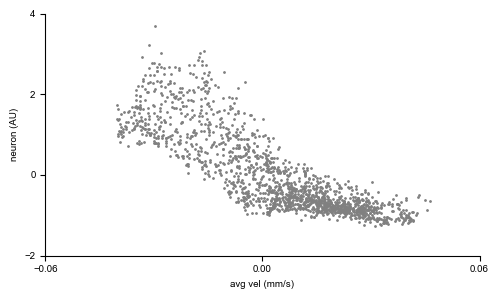

9

In [100]:
let
    dataset = "2021-05-26-07"
    neuron = 20

    rngs_use = get_pumping_ranges(datasets_baseline, analysis_dict["P_ranges"], rngs_valid=[1,2]);
    rng = rngs_use[dataset]

    τ = median(fit_results[dataset]["sampled_tau_vals"][rng, neuron, :])

    s = 1 / (2^(fit_results[dataset]["avg_timestep"] / τ) - 1)
    s0 = log(s / s_MEAN)
    
    v_ewma = model_nl8(1600, 0., 1., 0., 0., 0., 0., s0, 0., fit_results[dataset]["v"], zeros(1600), zeros(1600))

    σ_factor = v_STD
       
    # PyPlot.figure(figsize=(1.5,1)) # AI size
    PyPlot.figure(figsize=(5,3))
    PyPlot.scatter(v_ewma .* σ_factor,
        fit_results[dataset]["trace_array"][neuron,:], s=1, color="grey")
    PyPlot.xlabel("avg vel (mm/s)")
    PyPlot.ylabel("neuron (AU)")
    PyPlot.ylim(-2,4)
    PyPlot.yticks(-2:2:4)
    PyPlot.xticks(-0.06:0.06:0.06)
    PyPlot.xlim(-0.06,0.06)
    fix_plot()
    tight_layout()
    
    τ_rounded = Int(round(τ))
end

## Plot heatmaps of individual datasets (Figures 1E, 1G, 6E, and S1C)

0.6015765385927148


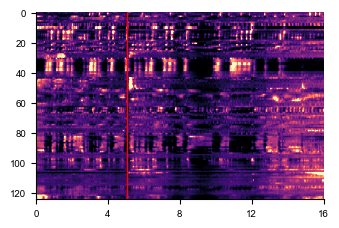

In [73]:
let
    data_uid = "2022-02-08-04"
    save_fig = false
    
    data_dict = import_data("/data1/prj_kfc/data/processed_h5/$(data_uid)-data.h5")
    
    list_confocal_Δt = diff(data_dict["timestamp_confocal"])
    @assert length(findall(list_confocal_Δt .> 1)) < 2
    confocal_Δt = mean(filter(x->x<1, list_confocal_Δt))
    println(confocal_Δt)
    data = data_dict["trace_array_F20"]

    array_dist = zeros(size(data,1), size(data,1))
    for i = 1:size(data,1), j = 1:size(data,1)
        array_dist[i,j] = cost_mse(data[i,:] |> FlavellBase.standardize, data[j,:] |>FlavellBase.standardize)
    end
    
    res_hc = hclust(array_dist, linkage=:single)
    clust_order = res_hc.order
    
    figure(figsize=(3.4,2.3))
    imshow(data[clust_order,:], aspect="auto",
        cmap="magma", vmax=2.5, vmin=0.5)

    PyPlot.xticks(collect(0:4:16) * 60 / confocal_Δt, 0:4:16)

    if data_uid in datasets_stim_all
        PyPlot.axvline((fit_results[data_uid]["ranges"][1][end]+1), color="red", linewidth=1)
    end
    ylabel("neuron #")
    xlabel("time (min)")
    xlim(0,16 * 60 / confocal_Δt)
    fix_plot()
    tight_layout()

    if save_fig
        create_dir(joinpath(path_fig_root, "figure7"))
        path_fig = joinpath(path_fig_root, "figure7/$data_uid-trace_heatstim.pdf")
        PyPlot.savefig(path_fig, transparent=true)
    end
end

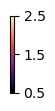

In [3]:
plot_colorbar(0.5, 2.5, [1.5], :magma, 256, (3,1))
# fix_plot()
# PyPlot.savefig(joinpath(path_fig_root, "figure7/heatmap_colorbar.pdf"), bbox_inches="tight", transparent=true)

# Heat-stimulus dataset analysis

## Plot event-triggered averages of neurons in response to the stim (Figures 7D-F)

This plot comes with three preset categories, depending on `plot_type`. You can also easily modify it to plot other sets of neurons.

- `sensory`: plot four neurons that have a sensory activation at the time of the stimulation, producing Figure 7D
- `sensory_inh`: plot four neurons that have a sensory inhibition at the time of the stimulation, producing Figure 7E
- `sensory_inh_inset`: plot the same four neurons as in `sensory_inh`, but with a different y-axis scale, producing the inset
- `state`: plot four neurons that have a state change at the time of the stimulation, producing Figure 7F

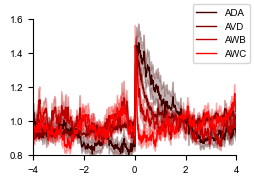

In [99]:
let
    save_fig = false
    plot_type = "sensory"
    spiking_neurons = []

    if plot_type in ["sensory_inh", "sensory_inh_inset"]
        neurons = reverse(["AIY", "OLL", "OLQD", "AIM"])
    elseif plot_type == "sensory"
        neurons = reverse(["AWC", "AWB", "AVD", "ADA"])
    elseif plot_type == "state"
        neurons = ["M1", "MI", "IL1V", "I2"]
    end


    gauss_conv_state = 15
    if plot_type in ["state", "sensory"]
        fig, ax1 = subplots(figsize=(2.5,1.8))
        if plot_type == "state"
            PyPlot.axvline(-gauss_conv_state/60, color="red", linewidth=0.5, linestyle="--")
            PyPlot.axvline(gauss_conv_state/60, color="red", linewidth=0.5, linestyle="--")

        end
    elseif !occursin("inset", plot_type)
        fig, ax1 = subplots(figsize=(2.5,1.8))
    else
        fig, ax1 = subplots(figsize=(1.1,0.65))
    end

    if plot_type == "state"
        colors = [RGB(0.6,0.7,0), RGB(0.3,0.4,0), RGB(0,0.7,0.3), RGB(0,0.4,0.15)]
    elseif plot_type == "sensory"
        colors = reverse([RGB(1,0,0), RGB(0.75,0,0), RGB(0.5,0,0), RGB(0.25,0,0)])
    elseif plot_type in ["sensory_inh", "sensory_inh_inset"]
        colors = reverse([RGB(0,0.66,1), RGB(0,0.44,0.8), RGB(0,0.22,0.6), RGB(0,0,0.4)])

    end

    ax2 = nothing

    max_spikerates = Dict()
    deltaTs = [5,10,20,40,60]
    for t in deltaTs
        max_spikerates[t] = 0
    end

    for (idx, neuron) in enumerate(neurons)
        avg_pre = Float64[]
        avg_post = Float64[]
        avg_post_400 = Float64[]

        if neuron in spiking_neurons
            gauss_conv = gauss_conv_state
        elseif plot_type == "state"
            gauss_conv = gauss_conv_state
        else
            gauss_conv = 0
        end
        peak_height = 3.
        x_rng = -8:0.01:8
        neural_traces = zeros(length([d for (d, n) in analysis_dict["matches"][neuron] if d in datasets_neuropal_stim]), length(x_rng))
        P_traces = zeros(length([d for (d, n) in analysis_dict["matches"][neuron] if d in datasets_neuropal_stim]), length(x_rng))
        min_val = minimum([stim_times[d] for d in datasets_neuropal_stim])
        count = 1
        for (d_, n_) in analysis_dict["matches"][neuron]
            if d_ in datasets_neuropal_stim
                dataset = d_

                timestep = fit_results[dataset]["avg_timestep"]

                peaks, peak_heights = find_peaks(fit_results[dataset]["trace_array"][n_,:], peak_height)
                indicator_peaks = zeros(size(fit_results[d_]["trace_array"],2))
                indicator_peaks[peaks] .= 60

                if neuron in spiking_neurons
                    for deltaT = keys(max_spikerates)
                        for t=1:length(indicator_peaks)-deltaT+1
                            if sum(indicator_peaks[t:t+deltaT-1]) / 60 > max_spikerates[deltaT]
                                max_spikerates[deltaT] = sum(indicator_peaks[t:t+deltaT-1]) / 60
                            end
                        end
                    end
                end

                kernel = [abs(x * fit_results[dataset]["avg_timestep"]) < gauss_conv ? 1.0 : 0.0 for x in -180:180]
                kernel = kernel ./ sum(kernel)
                data = (gauss_conv == 0) ? fit_results[d_]["trace_original"][n_, :] : CePNEMAnalysis.convolve(fit_results[d_]["trace_original"][n_, :], kernel)[181:end-180]

                if !(neuron in spiking_neurons)
                    data = data ./ mean(data)
                end
                intp = LinearInterpolation((1-stim_times[d_]:length(fit_results[d_]["trace_original"][n_, :])-stim_times[d_]) .* timestep ./ 60, data)

                neural_traces[count,:] .= intp.(x_rng)

                intp_P = LinearInterpolation((1-stim_times[d_]:length(fit_results[d_]["trace_original"][n_, :])-stim_times[d_]) .* timestep ./ 60, fit_results[d_]["P"])
                P_traces[count,:] .= intp_P.(x_rng)
                count += 1
            end
        end


        if plot_type == "pumping"
            data_plot = P_traces
        else
            data_plot = neural_traces
        end
        u = mean(data_plot, dims=1)[1,:]
        s = std(data_plot, dims=1)[1,:] / sqrt(count - 1)
        if neuron in spiking_neurons
            if isnothing(ax2)
                ax2 = ax1.twinx()   
            end

            ax2.plot(x_rng, u, linewidth=1, label=neuron, color=color_to_rgba(colors[idx], 1.0))
            ax2.fill_between(x_rng, u .- s, u .+ s, color=color_to_rgba(colors[idx], 0.3))

            ax2.set_ylim(0,2.0)
            ax2.set_yticks([0,0.5,1,1.5,2,2.0])
            ax2[:spines]["top"]["set_visible"](false);
        else
            ax1.plot(x_rng, u, linewidth=1, label=neuron, color=color_to_rgba(colors[idx], 1.0))
            ax1.fill_between(x_rng, u .- s, u .+ s, color=color_to_rgba(colors[idx], 0.3))
        end
    end

    inset_xlim = (-0.25, 0.75)
    inset_ylim = (0.55, 1.2)

    if plot_type in ["state", "pumping", "sensory", "sensory_inh"]
        ax1.set_xlim(-4,4)
        ax1.set_xticks(-4:2:4)
    elseif plot_type in ["sensory_inset"]
        ax1.set_xlim(-0.5,3.0)
        ax1.set_xticks(-0.5:0.5:3.0)
    elseif plot_type in ["sensory_inh_inset"]
        ax1.set_xlim(inset_xlim[1], inset_xlim[2])
    end
    if plot_type in ["sensory"]
        ax1.set_ylim(0.8,1.6)
    elseif plot_type == "state"
        ax1.set_ylim(0.7,1.3)
        ax1.set_yticks(0.7:0.2:1.3)
    elseif plot_type in ["sensory_inh"]
        ax1.set_ylim(0.5,1.3)
        ax1.set_yticks(0.5:0.2:1.3)
    elseif plot_type in ["sensory_inh_inset"]
        ax1.set_ylim(inset_ylim[1], inset_ylim[2])
    else
        ax1.set_ylim(0.6,1.8)
    end

    margins(0.05);
    tick_params(direction = "out");
    ax = gca();
    ax[:xaxis][:tick_bottom]();
    ax1[:spines]["top"]["set_visible"](false);
    tight_layout()
    show()

    if !any([n in spiking_neurons for n in neurons])
        fix_plot()
    end
    if plot_type in ["sensory_inh"]
        fig.legend(loc="lower right", bbox_to_anchor=(-0.2,0.49), bbox_transform=gca().transData)
    elseif plot_type in ["sensory"]
        fig.legend()
    elseif plot_type in ["state"]
        fig.legend(loc="lower right", bbox_to_anchor=(-1.55,1.15), bbox_transform=gca().transData)
    end

    if occursin("inset", plot_type)
        gca().set_xticks([])
        gca().set_yticks([])
        gca()[:spines]["right"]["set_visible"](true)
        gca()[:spines]["left"]["set_visible"](true)
        gca()[:spines]["top"]["set_visible"](true)
        gca()[:spines]["bottom"]["set_visible"](true)
        for spine in ["right", "left", "top", "bottom"]
            gca()[:spines][spine]["set_edgecolor"]("black")
            gca()[:spines][spine]["set_linewidth"](2)
        end

        tight_layout()
        subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    end
    if save_fig
        save_path = joinpath(path_fig_root, "figure7")
        create_dir(save_path)
        save_path = joinpath(save_path, "etas")
        create_dir(save_path)
        PyPlot.savefig(joinpath(save_path, "neural_trace_$(plot_type).pdf"), transparent=(plot_type != "sensory_inh_inset"))
    end
end

## Plot neurons in response to the stim (Figure 7I)

You can change `neurons_find` and `dataset` to change which dataset and neurons to examine. Note that not all neurons are detected in all datasets, so you may need to change `neurons_find` depending on the dataset.

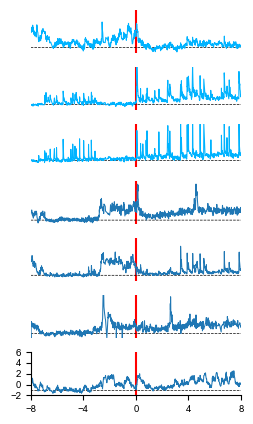

In [88]:
let
    neurons_find = ["M3", "MC", "M4", "AIN", "I2", "MI"]
    dataset = "2023-01-10-14"
    save_fig = false

    datasets_all = [d for d in datasets_neuropal_stim if all([any(x[1] == d for x in analysis_dict["matches"][n]) for n in neurons_find])]
    idx = 5


    plot_type = "both"
    x_lim = (-8,8)

    x_rng = (collect(1:size(fit_results[dataset]["trace_array"],2)) .- stim_times[dataset]) .* fit_results[dataset]["avg_timestep"] ./ 60

    if plot_type == "activated"
        fig = PyPlot.figure(figsize=(3,3))
    elseif plot_type == "state"
        fig = PyPlot.figure(figsize=(3,1.5))
    elseif plot_type == "pumping"
        fig = PyPlot.figure(figsize=(2.5,1.0))
    elseif plot_type == "both"
        fig = PyPlot.figure(figsize=(2.546,4.25))
    end

    if plot_type == "state"
        neurons_plot = ["MI", "I2"]
    elseif plot_type == "activated"
        neurons_plot = ["MC", "M3", "M4", "AIN"]
    elseif plot_type == "pumping"
        neurons_plot = []
    elseif plot_type == "both"
        neurons_plot = ["I2", "M1", "MI", "MC", "M3", "M4", "AIN"]
    end
    if plot_type == "pumping"
        gca().axvline(0, color="red")
        PyPlot.plot(x_rng, fit_results[dataset]["P"], color="black", label="P")
    else
        for (i,neuron) in enumerate(neurons_plot)
            offset = 0
            if neuron == "MI"
                color = (0,0.7,1)
            elseif neuron == "I2"
                color = (0,0.7,1)
            elseif neuron == "M3"
                color = "C0"
                offset = 3
            elseif neuron == "MC"
                color = "C0"
                offset = 8
            elseif neuron == "M4"
                color = "C0"
                offset = 14
            elseif neuron == "AIN"
                color = "C0"
                offset = 0
            elseif neuron == "M1"
                color = (0,0.7,1)
            else
                color = (0,0.7,1)
            end
            neuron_matches = [x[2] for x in analysis_dict["matches"][neuron] if x[1] == dataset]
            if plot_type in ["activated", "both"]
                data_plot = mean(fit_results[dataset]["trace_array"][neuron_matches, :], dims=1)[1,:]
                ax = fig.add_subplot(length(neurons_plot),1,i)
                ax.axvline(0, color="red")
                ax.plot(x_rng, fill(percentile(data_plot, 10), length(x_rng)), color="black", linestyle="--", linewidth=0.5)
                ax.plot(x_rng, data_plot, color=color, label=neuron, linewidth=0.75)
                ax.set_ylim(-2,6)
                ax.set_xlim(-8,8)
                ax[:xaxis][:tick_bottom]();
                ax[:yaxis][:tick_left]();
                ax[:spines]["top"]["set_visible"](false);
                ax[:spines]["right"]["set_visible"](false);
                if i != length(neurons_plot)
                    ax.spines["bottom"].set_visible(false)
                    ax.spines["left"].set_visible(false)
                    ax.set_yticks([])
                    ax.set_yticklabels([])
                    ax.set_xticks([])
                    ax.set_xticklabels([])
                else
                    ax.set_yticks(-2:2:6)
                end
            else
                PyPlot.plot(x_rng, mean(fit_results[dataset]["trace_array"][neuron_matches, :] .+ offset, dims=1)[1,:], color=color, label=neuron, linewidth=0.5)
            end
        end
    end
    

    if plot_type == "state"
        PyPlot.ylim(-2,8)
        fig.legend(loc="upper left", bbox_to_anchor=(-8,9), bbox_transform=gca().transData)
    elseif plot_type == "activated"
        subplots_adjust(hspace=0)
    elseif plot_type == "pumping"
        PyPlot.ylim(-0.2,3)
        PyPlot.yticks(0:1:3)
    end

    PyPlot.xticks(-8:4:8)

    if plot_type != "activated"
        PyPlot.xlim(x_lim...)
        gca()[:spines]["top"]["set_visible"](false);
        gca()[:spines]["right"]["set_visible"](false);
        gca()[:xaxis][:tick_bottom]();
        gca()[:yaxis][:tick_left]();
    end


    tight_layout()
    
    if save_fig
        create_dir(joinpath(path_fig_root, "figure7"))
        create_dir(joinpath(path_fig_root, "figure7", "example_pumping_dataset"))
        if plot_type == "state"
            PyPlot.savefig(joinpath(path_fig_root, "figure7", "example_pumping_dataset", "state_neurons.pdf"), bbox_inches="tight", transparent=true)
        elseif plot_type == "activated"
            PyPlot.savefig(joinpath(path_fig_root, "figure7", "example_pumping_dataset", "activated_neurons.pdf"), bbox_inches="tight", transparent=true)
        elseif plot_type == "pumping"
            PyPlot.savefig(joinpath(path_fig_root, "figure7", "example_pumping_dataset", "pumping.pdf"), bbox_inches="tight", transparent=true)
        elseif plot_type == "both"
            PyPlot.savefig(joinpath(path_fig_root, "figure7", "example_pumping_dataset", "both.pdf"), bbox_inches="tight", transparent=true)
        end
    end
end

## Plot fraction of encoding change in feeding neurons (Figure S7F)

You can change `neurons_sig` to change which neurons to examine. It is recommended to only examine neurons that appear in "Neurons to be considered" in the "Feeding encoding change analysis" section of the `CePNEM-analysis.ipynb` notebook, as other neurons do not have enough feeding information for this analysis to be meaningful.

0.9615384615384616
0.9333333333333333
0.9
0.7


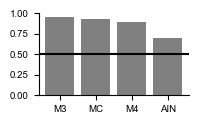

In [98]:
let
    neurons_sig = ["M3", "MC", "M4", "AIN"]

    save_fig = false
    sigma = 0
    dict_use = analysis_dict["pumping_degradation"]
    StatsPlots.plot(size=(200,125), xtickfont=font("Arial", 7, "black"), ytickfont=font("Arial", 7, "black"), tick_direction=:out)

    frac_pos = Float64[]
    for neuron in neurons_sig
        prestim_mse_diff = mean(dict_use["mse_prestim_null"][neuron]) - mean(dict_use["mse_prestim"][neuron])
        poststim_mse_diff = mean(dict_use["mse_poststim_null"][neuron]) - mean(dict_use["mse_poststim"][neuron])
        stim_diff = dict_use["mse_prestim_null"][neuron] .- dict_use["mse_prestim"][neuron] .- (dict_use["mse_poststim_null"][neuron] .- dict_use["mse_poststim"][neuron])
        push!(frac_pos, sum(stim_diff .> 0) / length(stim_diff))
        println(frac_pos[end])
    end

    PyPlot.figure(figsize=(2.0,1.25))
    PyPlot.axhline(0.5, color="black", label=nothing)

    PyPlot.bar(1:length(frac_pos), frac_pos, label=nothing, color="grey")

    PyPlot.xticks(1:length(neurons_sig), neurons_sig)
    PyPlot.ylim(0,1)
    fix_plot()
    tight_layout()

    if save_fig
        save_dir = joinpath(path_fig_root, "figureS7")
        create_dir(save_dir)
        save_dir = joinpath(save_dir, "global_stim_response")
        create_dir(save_dir)
        PyPlot.savefig(joinpath(save_dir, "pumping_decoding_diff.pdf"), transparent=true)
    end
end
        

## Plot tuning curves of neural activity to feeding (bottom of Figure 7J)

You can change the `for` loop argument to change which neurons to examine.

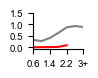

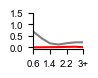

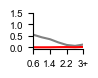

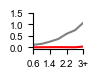

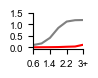

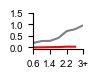

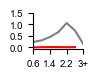

In [ ]:
let
    for neuron = ["I2", "M1", "MI", "MC", "M3", "M4", "AIN"]
        save_fig = true

        neurons_spiking = ["M1", "MI"]

        P_bins = 0.0:0.2:3.0
        neuron_bins = 0.6:0.4:3.0

        P_vs_neuron_heatmap_baseline = zeros(length(P_bins), length(neuron_bins))
        neuron_vals_per_P_baseline = [Float64[] for i=1:length(P_bins)]
        P_vals_per_neuron_baseline = [Float64[] for i=1:length(neuron_bins)]


        P_vs_neuron_heatmap_stim = zeros(length(P_bins), length(neuron_bins))
        neuron_vals_per_P_stim = [Float64[] for i=1:length(P_bins)]
        P_vals_per_neuron_stim = [Float64[] for i=1:length(neuron_bins)]
        percent_P_thresh = 12.5
        percent_norm = 10
        spike_thresh = 2.0

        
        for data_use = ["baseline_prestim", "poststim"]
            for (dataset, n) in analysis_dict["matches"][neuron]
                # ensure F/F10 works as intended
                if dataset in datasets_neuropal_baseline && percentile(fit_results[dataset]["P"], percent_P_thresh) > 0
                    continue
                end
                if dataset in datasets_neuropal_stim && percentile(fit_results[dataset]["P"][fit_results[dataset]["ranges"][1]], percent_P_thresh*maximum(fit_results[dataset]["ranges"][end])/maximum(fit_results[dataset]["ranges"][1])) > 0
                    continue
                end
                if data_use == "poststim" && dataset in datasets_neuropal_baseline
                    continue
                end
                perc = percentile(fit_results[dataset]["trace_original"][n,:], percent_norm)
                for t = 1:length(fit_results[dataset]["P"])
                    if (data_use == "poststim" && t <= stim_times[dataset]) || (data_use == "baseline_prestim" && dataset in datasets_neuropal_stim && t >= stim_times[dataset])
                        continue
                    end
                    P_bin = findlast(x -> x <= fit_results[dataset]["P"][t], P_bins)
                    neuron_act = fit_results[dataset]["trace_original"][n,t] / perc

                    neuron_bin = findlast(x -> x <= neuron_act, neuron_bins)
                    if isnothing(neuron_bin)
                        neuron_bin = 1
                    end
                    if data_use == "baseline_prestim"
                        P_vs_neuron_heatmap_baseline[P_bin, neuron_bin] += 1
                    elseif data_use == "poststim"
                        P_vs_neuron_heatmap_stim[P_bin, neuron_bin] += 1
                    end

                    if data_use == "baseline_prestim"
                        push!(neuron_vals_per_P_baseline[P_bin], neuron_act)
                        push!(P_vals_per_neuron_baseline[neuron_bin], fit_results[dataset]["P"][t])
                    elseif data_use == "poststim"
                        push!(neuron_vals_per_P_stim[P_bin], neuron_act)
                        push!(P_vals_per_neuron_stim[neuron_bin], fit_results[dataset]["P"][t])
                    end
                end
            end
        end

        max_idx_baseline = findfirst(x->length(x)<200, neuron_vals_per_P_baseline)
        if isnothing(max_idx_baseline)
            max_idx_baseline = length(P_bins)
        end
        max_idx_P_baseline = findfirst(x->length(x)<200, P_vals_per_neuron_baseline[2:end])
        if isnothing(max_idx_P_baseline)
            max_idx_P_baseline = length(neuron_bins)-1
        end
        max_idx_stim = findfirst(x->length(x)<200, neuron_vals_per_P_stim)
        if isnothing(max_idx_stim)
            max_idx_stim = length(P_bins)
        end
        max_idx_P_stim = findfirst(x->length(x)<200, P_vals_per_neuron_stim[2:end])
        if isnothing(max_idx_P_stim)
            max_idx_P_stim = length(neuron_bins)-1
        end
        y_vals_baseline = [mean(neuron_vals_per_P_baseline[P_bin]) for P_bin = 1:length(P_bins)]
        y_vals_stim = [mean(neuron_vals_per_P_stim[P_bin]) for P_bin = 1:length(P_bins)]

        P_vals_baseline = [mean(P_vals_per_neuron_baseline[neuron_bin]) for neuron_bin = 1:length(neuron_bins)]
        P_vals_stim = [mean(P_vals_per_neuron_stim[neuron_bin]) for neuron_bin = 1:length(neuron_bins)]
        figure(figsize=(1,0.8))


        PyPlot.plot(neuron_bins[1:max_idx_P_baseline+1], P_vals_baseline[1:max_idx_P_baseline+1], color="grey")
        PyPlot.plot(neuron_bins[1:max_idx_P_stim+1], P_vals_stim[1:max_idx_P_stim+1], color="red")

        PyPlot.ylim(-0.08,1.5)
        PyPlot.yticks(0:0.5:1.5)
        PyPlot.xlim(0.6,3.0)
        PyPlot.xticks(0.6:0.8:3.0, [x == 3 ? "3+" : "$x" for x in 0.6:0.8:3.0])
        fix_plot()
        tight_layout()

        if save_fig
            create_dir(joinpath(path_fig_root, "figure7", "P_vs_neuron_tuning"))
            PyPlot.savefig(joinpath(path_fig_root, "figure7", "P_vs_neuron_tuning", "$(neuron).pdf"))
        end
    end
end
